In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import numpy as np
from shapely import wkt, centroid, distance

In [2]:
cent = pd.read_csv('data/network_stats/network_stats.csv')
cent

,osmid,y,x,street_count,ref,highway,geometry,betweenness_w_bridge,betweenness_wo_bridge,closeness_w_bridge,closeness_wo_bridge,eigenvector_w_bridge,eigenvector_wo_bridge,straightness_w_bridge,straightness_wo_bridge
0,27033798,39.267199,-76.622936,3,NaN,NaN,POINT (1419090.761762985 583119.9161354963),0.000665,0.000665,0.000096,0.000096,5.325009e-14,5.325009e-14,0.721232,0.721232
1,27033900,39.272539,-76.554497,3,57,motorway_junction,POINT (1438458.0374937304 585151.927322653),0.001382,0.001382,0.000086,0.000086,1.678591e-08,1.678591e-08,0.763005,0.763005
2,27033915,39.284076,-76.546532,3,NaN,NaN,POINT (1440692.1008482885 589365.4433808434),0.000321,0.000321,0.000097,0.000097,6.653690e-07,6.653690e-07,0.679640,0.679640
3,33131447,39.321996,-76.631529,3,8,motorway_junction,POINT (1416577.2822272035 603068.7750235201),0.009016,0.009016,0.000147,0.000147,1.686537e-18,1.686537e-18,0.660387,0.660387
4,33131448,39.320702,-76.630708,3,NaN,NaN,POINT (1416811.3416445032 602598.3954782601),0.009016,0.009016,0.000151,0.000151,-4.221257e-19,-4.221257e-19,0.643006,0.643006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12505,11030012245,39.346441,-76.707787,3,NaN,NaN,POINT (1394974.8906208077 611894.3747400221),0.001274,0.001274,0.000090,0.000090,2.522182e-18,2.522182e-18,0.836157,0.836157
12506,11088371136,39.265642,-76.562955,3,NaN,NaN,POINT (1436075.3851187371 582628.2836832016),0.000776,0.000776,0.000079,0.000079,1.125513e-13,1.125513e-13,0.718513,0.718513
12507,11335249403,39.286276,-76.620727,4,NaN,traffic_signals,POINT (1419687.2883934795 590070.7032583684),0.016197,0.016197,0.000153,0.000153,3.245557e-12,3.245557e-12,0.865141,0.865141
12508,11337250637,39.238535,-76.609528,4,NaN,traffic_signals,POINT (1422931.4108149156 572695.7190721752),0.033738,0.033738,0.000091,0.000091,9.793411e-11,9.793411e-11,0.846316,0.846316


In [6]:
(cent['eigenvector_w_bridge'] != cent['eigenvector_wo_bridge']).sum()

0

In [20]:
# read network
roads_G = nx.read_gml('data/network/BMA_road_network.gml')
roads_df = pd.read_csv('data/network/BMA_roads.csv')
roads_df['u'], roads_df['v'] = roads_df['u'].astype(str), roads_df['v'].astype(str)

/var/folders/7l/ffzd6jqd4k1g060d9whf4v2c0000gn/T/ipykernel_37034/261005585.py:3: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  roads_df = pd.read_csv('data/network/BMA_roads.csv')


In [17]:
# bridge collapse
roads_wo_bridge_G = roads_G.copy()
destroyed_edges = roads_df[roads_df['highway'] == 'destroyed']
destroyed_edges = list(zip(destroyed_edges['u'].astype(str), destroyed_edges['v'].astype(str))) # start and end nodes
roads_wo_bridge_G.remove_edges_from(destroyed_edges) # python multiprocessing doesn't share state

In [18]:
destroyed_edges

[]

In [22]:
roads_df[roads_df['highway'] == 'destroyed']

,u,v,key,osmid,oneway,lanes,name,highway,reversed,length,geometry,maxspeed,junction,ref,bridge,access,tunnel,width,service
127492,11763173294,11763173296,0,"[1266408369, 1026914410, 1266408372, 1266869151]",False,2,Baltimore Beltway,destroyed,False,1074.053,LINESTRING (1445069.2788659881 564031.54219064...,NaN,NaN,I 695,NaN,NaN,NaN,NaN,NaN
127493,11763173295,11763173297,0,"[1266408370, 1266408371, 1266869150, 1026914407]",False,2,Baltimore Beltway,destroyed,True,1074.275,LINESTRING (1445046.076718198 564052.949097434...,NaN,NaN,I 695,NaN,NaN,NaN,NaN,NaN
127495,11763173296,11763173294,0,"[1266408369, 1026914410, 1266408372, 1266869151]",False,2,Baltimore Beltway,destroyed,True,1074.053,LINESTRING (1447564.0251093109 566522.24926747...,NaN,NaN,I 695,NaN,NaN,NaN,NaN,NaN
127497,11763173297,11763173295,0,"[1266408370, 1266408371, 1266869150, 1026914407]",False,2,Baltimore Beltway,destroyed,False,1074.275,LINESTRING (1447543.29547897 566542.2099804487...,NaN,NaN,I 695,NaN,NaN,NaN,NaN,NaN


In [5]:
df = pd.read_csv('data/network_stats/spaths_length_w_bridge.csv')

In [8]:
df['path_len'].mean()

21557.48190071363

In [28]:
jtw_from_bma = pd.read_csv('data/utilization/2012-2016_CTPP_worker_flows_tract_to_tract_(from_BMC_area).csv')
jtw_from_bma['RES_FIPS'], jtw_from_bma['WP_FIPS'] = jtw_from_bma['RES_FIPS'].astype(str), jtw_from_bma['WP_FIPS'].astype(str)

jtw_to_bma = pd.read_csv('data/utilization/2012-2016_CTPP_worker_flows_tract_to_tract_(to_BMC_area).csv')
jtw_to_bma['RES_FIPS'], jtw_to_bma['WP_FIPS'] = jtw_to_bma['RES_FIPS'].astype(str), jtw_to_bma['WP_FIPS'].astype(str)

# combine both
jtw = jtw_from_bma[['RES_FIPS', 'WP_FIPS', 'EST']].rename(columns={
    'EST': 'EST_from'
}).merge(
    right=jtw_to_bma[['RES_FIPS', 'WP_FIPS', 'EST']].rename(columns={
        'EST': 'EST_to'
    }),
    on=['RES_FIPS', 'WP_FIPS'],
    how='outer'
)

## ratios excluded
exc_from_bma = jtw.loc[jtw['EST_to'].isna(), 'EST_from'].sum() / jtw['EST_from'].sum()
print(f'Percent Excluded Who Travel from BMA: {exc_from_bma}')
exc_to_bma = jtw.loc[jtw['EST_from'].isna(), 'EST_to'].sum() / jtw['EST_to'].sum()
print(f'Percent Excluded Who Travel to BMA: {exc_to_bma}')

# drop out of BMA tracts
jtw = jtw.dropna()

# check files were the same
assert (jtw['EST_from'] == jtw['EST_to']).all()

jtw = jtw.drop(columns='EST_to').rename(columns={
    'RES_FIPS': 'home',
    'WP_FIPS': 'work',
    'EST_from': 'flow'
})

## Census tract locations (Requires JTW Data)
us_tracts = gpd.read_file('data/utilization/cb_2019_us_tract_500k2019/cb_2019_us_tract_500k.shp')
# us_tracts['GEOID'] = pd.to_numeric(us_tracts['GEOID'])
us_tracts = us_tracts[us_tracts['GEOID'].isin(np.concatenate((jtw['home'], jtw['work'])))] # only include tracts in BMA
us_tracts = us_tracts.to_crs('EPSG:2893') # convert coords
us_tracts = us_tracts[['GEOID', 'geometry']].rename(columns={
    'GEOID': 'tract'
})

# merge with utilization
us_tracts = us_tracts.merge(
    right=jtw[['home', 'flow']].groupby(
        'home'
    ).sum().reset_index().rename(columns={
        'flow': 'residents'
    }),
    left_on='tract',
    right_on='home',
    how='left'
).drop(columns='home').merge(
    right=jtw[['work', 'flow']].groupby(
        'work'
    ).sum().reset_index().rename(columns={
        'flow': 'workers'
    }),
    left_on='tract',
    right_on='work',
    how='left'
).drop(columns='work')

Percent Excluded Who Travel from BMA: 0.12240195934395855
Percent Excluded Who Travel to BMA: 0.11101928905214539


In [36]:
def get_closest_intersection(tracts: gpd.GeoDataFrame
                             ) -> None:
    # get intersections
    intersections = pd.read_csv('data/network/BMA_intersections.csv')
    intersections['geometry'] = intersections['geometry'].apply(wkt.loads)
    intersections = gpd.GeoDataFrame(intersections, geometry='geometry')

    for i in tracts.index:
        dists = distance(centroid(tracts.loc[i, 'geometry']), intersections['geometry'])
        closest_intersection = intersections.index[np.argmin(dists)]
        tracts.loc[i, 'intersection'] = intersections.loc[closest_intersection, 'osmid']
        tracts.loc[i, 'intersection_geom'] = intersections.loc[closest_intersection, 'geometry']

In [37]:
get_closest_intersection(us_tracts)

In [41]:
us_tracts

,tract,geometry,residents,workers,intersection,intersection_geom
0,24005408601,"POLYGON ((1417859.486 646373.170, 1418243.007 ...",1805.0,692.0,3.770918e+07,POINT (1421183.592739176 645526.6844467338)
1,24005490703,"POLYGON ((1418529.034 630280.821, 1419612.948 ...",1533.0,6762.0,3.774788e+07,POINT (1421794.1584747583 631620.3484133456)
2,24510260202,"POLYGON ((1435115.788 605243.428, 1435635.070 ...",1849.0,128.0,4.954124e+07,POINT (1437334.578407478 604061.3393757134)
3,24005430104,"POLYGON ((1413755.705 570298.826, 1413907.538 ...",1310.0,263.0,3.767014e+07,POINT (1414871.8498781554 572260.9381405239)
4,24510150100,"POLYGON ((1412781.628 598667.009, 1413486.544 ...",552.0,135.0,4.953417e+07,POINT (1413660.3150092973 597158.876955188)
...,...,...,...,...,...,...
673,24027606604,"POLYGON ((1359130.918 562012.610, 1359504.842 ...",1549.0,168.0,1.612332e+09,POINT (1361218.6854271586 559293.4661393065)
674,24003751000,"POLYGON ((1419405.082 545763.640, 1419560.010 ...",1370.0,1328.0,1.026037e+08,POINT (1422632.0713415805 546556.1345608453)
675,24005452400,"POLYGON ((1448250.590 592461.370, 1448465.416 ...",1380.0,3738.0,3.110696e+09,POINT (1461844.5224454626 585127.1929690129)
676,24005405000,"POLYGON ((1357267.101 695275.721, 1358372.298 ...",2013.0,667.0,3.773673e+07,POINT (1378307.662536724 701864.7845711168)


,home,work,flow,home_node,work_node
0,24003701101,24003701101,270.0,1.025896e+08,102589569.0
1,24003701102,24003701101,90.0,1.025984e+08,102589569.0
2,24003701200,24003701101,75.0,1.026008e+08,102589569.0
3,24003701300,24003701101,15.0,1.026283e+08,102589569.0
4,24003702204,24003701101,10.0,1.025792e+08,102589569.0
...,...,...,...,...,...
41267,24510160700,24510150702,20.0,1.409337e+09,49542192.0
41268,24510280200,24510150702,15.0,4.948326e+07,49542192.0
41269,24510250402,24510250402,80.0,4.948550e+07,49485500.0
41270,24510270301,24510250402,4.0,4.948492e+07,49485500.0


In [ ]:
us_tracts

<Axes: >

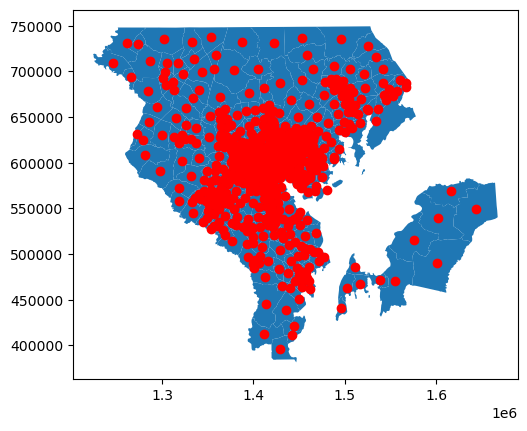

In [50]:
ax = plt.subplot()

us_tracts.plot(ax=ax)

gpd.GeoDataFrame(us_tracts['intersection_geom'], geometry='intersection_geom').plot(ax=ax, color='red')